In [1]:
import os
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
import pandas as pd

In [2]:
folder_dataset = 'data/images'
seed = 2704

In [3]:
files = [file for file in os.listdir(folder_dataset) if file.endswith('.jpg')]
len(files)

1180

sections = 5
data = pd.DataFrame(columns=['img_name', 'folder','image', 'section'])
for file in files:
    image = load_image(file)
    width = int(image.shape[1]/sections)
    for i in range(0,sections):
        img_cut=image[:,width*i:width*(i+1),:]
        img = cv.cvtColor(img_cut, cv.COLOR_RGB2BGR)
        cv.imwrite('data/images/'+file[:-4]+'_'+str(i)+'.jpg', img)
        data = data.append({'img_name': file[:-4]+'_'+str(i),'folder': int(file[6:8]), 'image': int(file[13:-4]), 'section':i}, ignore_index=True)
data.to_csv('data/data_category.csv', index=False, sep=';', decimal=".")

In [4]:
def load_image(img_name):
    img = cv.imread(os.path.join(folder_dataset, img_name))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    return img

def process_image(img, show_process=False, clahe_tile=(19,19), kernel_size=(37,37)):
    # Preprocess
    #smoothed = cv.blur(img,(5,5))
    denoise = cv.fastNlMeansDenoising(img,None,21,7)
    # Convert to gray
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # CLAHE
    clahe_filter = cv.createCLAHE(clipLimit=3,tileGridSize=clahe_tile)
    clahe = clahe_filter.apply(img_gray)
    #clahe = cv.equalizeHist(img_gray)
    # Otsu
    _, otsu = cv.threshold(clahe,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
    # Closing (Dilate+Erode)
    kernel = np.ones(kernel_size,np.uint8)
    closing = cv.morphologyEx(otsu, cv.MORPH_OPEN, kernel)
    # Fill holes    
    holes = closing.copy()
    contours,_ = cv.findContours(holes,cv.RETR_CCOMP,cv.CHAIN_APPROX_SIMPLE)
    limit = img.shape[0]*img.shape[1]*0.05
    for contour in contours:
        area = cv.contourArea(contour)
        if area<limit:
            cv.drawContours(holes,[contour],0,0, thickness=cv.FILLED)
    if show_process:
        fig, axs = plt.subplots(1, 7, figsize=(16,5)) 
        axs[0].imshow(img)
        axs[0].axis('off')
        axs[0].set_title('(a) Original')
        axs[1].imshow(denoise)
        axs[1].axis('off')
        axs[1].set_title('(b) Preprocess')
        axs[2].imshow(clahe, cmap='gray')
        axs[2].axis('off')
        axs[2].set_title('(c) Gray and CLAHE')
        axs[3].imshow(otsu, cmap='gray')
        axs[3].axis('off')
        axs[3].set_title('(d) Otsu')
        axs[4].imshow(closing, cmap='gray')
        axs[4].axis('off')
        axs[4].set_title('(e) Closing')
        axs[5].imshow(holes, cmap='gray')
        axs[5].axis('off')
        axs[5].set_title('(f) Fill holes')
        axs[6].axis('off')
        axs[6].set_title('(g) Contour features')
        #plt.show()
    return holes

In [5]:
def percentage_white_pixels(image, height):
    img_cut1 = image[0:height+1,:]
    total_pixels_section = img_cut1.shape[0]*img_cut1.shape[1]
    pixels1 = np.count_nonzero(img_cut1 == 255)
    pwp1 = (pixels1*100)/total_pixels_section
    
    img_cut2 = image[height:image.shape[0],:]
    total_pixels_section = img_cut2.shape[0]*img_cut2.shape[1]
    pixels2= np.count_nonzero(img_cut2 == 255)
    pwp2 = (pixels2*100)/total_pixels_section
    return [pwp1, pwp2, pixels1, pixels2]

def cut_section(image, return_process=False, calculate_features=False):
    contours,_ = cv.findContours(image,cv.RETR_CCOMP,cv.CHAIN_APPROX_SIMPLE)
    img = cv.cvtColor(image,cv.COLOR_GRAY2RGB)
    biggest_contour = []
    biggest_area = 0
    final_data = {}
    for contour in contours:
        area = cv.contourArea(contour)
        if area>biggest_area:
            biggest_contour = contour
            biggest_area = area
    if biggest_area>0:        
        rows,cols = img.shape[:2]
        
        min_col0 = rows
        max_col0 = 0
        min_cols = rows
        max_cols = 0
        contour = []
        for point in biggest_contour:
            if point[0][0]==0:
                if point[0][1]> max_col0:
                    max_col0 = point[0][1]
                if point[0][1]< min_col0:
                    min_col0 = point[0][1]
            if point[0][0]==(cols-1):
                if point[0][1]> max_cols:
                    max_cols = point[0][1]
                if point[0][1]< min_cols:
                    min_cols = point[0][1]
            contour.append([point[0][0], point[0][1]])
        final_data['biggest_contour'] = contour
        
        diff_ymax = abs(rows-max_col0)
        if diff_ymax>min_col0:
            y_value = max_col0
        else:
            y_value = min_col0
        if y_value<image.shape[0] and y_value>0:
            pwp1, pwp2, _, _ = percentage_white_pixels(image, int(y_value))        
            if pwp1>pwp2:
                final_data['sign'] = 1
                begin_point = [0,max_col0]
                end_point = [cols-1,max_cols]
            else: 
                final_data['sign'] = -1
                begin_point = [0,min_col0]
                end_point = [cols-1,min_cols]
            if begin_point in contour and end_point in contour:
                index_begin = contour.index(begin_point)
                index_end = contour.index(end_point)
                contour_line = contour[index_begin:index_end+1]
                if contour_line[1][0]==0:
                    contour_line = contour[index_end:] + contour[:index_begin+1]
                final_data['contour_line'] = contour_line

                min_line = begin_point[1]
                max_line = 0
                for point in contour_line:
                    if point[1]<min_line:
                        min_line = point[1]
                    if point[1]>max_line:
                        max_line = point[1]

                final_data['y1'] = min_line
                final_data['y2'] = max_line
                final_data['dist'] = max_line - min_line

                if return_process:
                    cv.rectangle(img,(0,min_line),(cols-1,max_line),(255,0,0),1)

                if calculate_features:

                    line_point = np.array(contour_line , dtype=np.int32)
                    X = np.reshape(line_point[:,0], (len(line_point), -1))
                    y = line_point[:,1]
                    reg = LinearRegression().fit(X, y)
                    final_data['slope'] = reg.coef_[0]
                    
                    middle = int((min_line+max_line)/2)
                    validation = True
                    if final_data['sign'] == 1:
                        if (max_line+1)<image.shape[0]:
                            _, _, pixels_limit ,  _= percentage_white_pixels(image, int(max_line+1))
                            _, _, pixels_middle ,  _= percentage_white_pixels(image, int(middle+1))
                        else:
                            validation = False
                    else:
                        if min_line>0:
                            _, _, _,  pixels_limit= percentage_white_pixels(image, int(min_line-1))
                            _, _, _,  pixels_middle= percentage_white_pixels(image, int(middle-1))
                        else:
                            validation = False
                    if validation:
                        total_pixels = image.shape[0]*image.shape[1]
                        final_data['pwp_limit']  =  pixels_limit/total_pixels
                        final_data['pwp_middle']  = pixels_middle/total_pixels

                        if final_data['sign'] == 1:
                            beginning_point = [0,min_line]
                            ending_point = [img_process_cut.shape[1]-1,min_line]
                        else:
                            beginning_point = [0,max_line]
                            ending_point = [img_process_cut.shape[1]-1,max_line]

                        if contour_line[0][0] == 0:
                            complete_contour = np.array([beginning_point] + contour_line + [ending_point], dtype=np.int32)
                        else:
                            complete_contour = np.array([ending_point] + contour_line + [beginning_point], dtype=np.int32)

                        area = cv.contourArea(complete_contour)
                        x,y,w,h = cv.boundingRect(complete_contour)
                        rect_area = w*h
                        extent = float(area)/rect_area
                        final_data['extent'] = extent

                        hull = cv.convexHull(complete_contour)
                        hull_area = cv.contourArea(complete_contour)
                        solidity = float(area)/hull_area
                        final_data['solidity'] = solidity        

                        if return_process:
                            cv.drawContours(img, [complete_contour], 0, (0,255,0), 1)
                            cv.rectangle(img,(x,y),(x+w,y+h),(255,0,0),1)
                            cv.drawContours(img, [hull], 0, (255, 233, 0), 1)
        if return_process:
            if not calculate_features:
                cv.drawContours(img, [biggest_contour], 0, (0,255,0), 1)
            final_data['img'] = img
    return final_data


Pieza_01_foto00_0.jpg


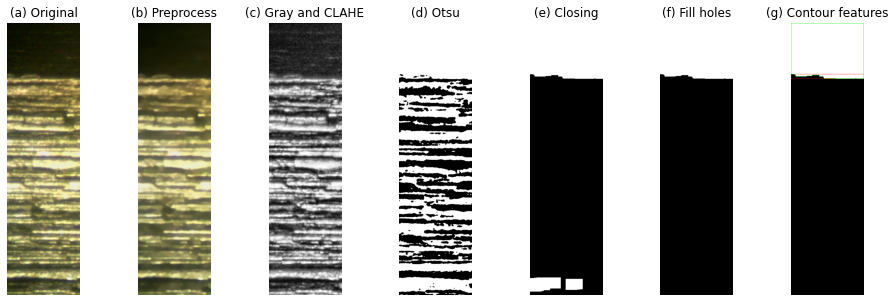

In [6]:
file = files[0]
print(file)
image = load_image(file)
img_process = process_image(image, True)
data_vector =  cut_section(img_process, True)
plt.imshow(data_vector['img'])
plt.axis('off')
plt.show()

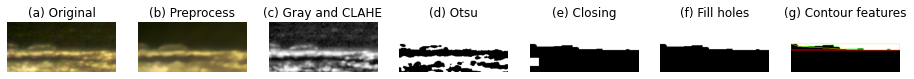

In [7]:
img_cut=image[data_vector['y1']-50:data_vector['y2']+50,:]
img_process_cut = process_image(img_cut, True, clahe_tile = (5,5), kernel_size=(17,39))

data_vector_cut =  cut_section(img_process_cut, True, True)#, diff_max=0.005)  
plt.imshow(data_vector_cut['img'])
plt.axis('off')
plt.show()

In [8]:
data = pd.DataFrame(columns=['img_name', 'folder','image', 'section']+['dist', 'extent', 'solidity', ' slope', 'pwp_limit', 'pwp_middle'])
cont = 1
for file in files:
    print(cont,file, data.shape)
    cont += 1
    image = load_image(file)
    img_process = process_image(image, True)    
    
    data_vector =  cut_section(img_process, True)
    if "dist" in data_vector:        
        plt.imshow(data_vector['img'])
        plt.axis('off')
        plt.savefig('data/test/'+file[:-4]+'_process.jpg', dpi=200, bbox_inches='tight', pad_inches=0)

        y1 = data_vector['y1']-50
        y1 = 0 if y1<0 else y1
        y2 = data_vector['y2']+50
        y2 = (img_process.shape[0]-1) if y2>(img_process.shape[0]-1) else y2
        img_cut=image[y1:y2,:]

        if img_cut.shape[0]>10:
            img_process_cut = process_image(img_cut, True, clahe_tile = (5,5), kernel_size=(15,39))
            
            data_vector_cut =  cut_section(img_process_cut, True, True)  
            
            if "solidity" in data_vector_cut:
                data = data.append({'img_name': file[:-4],'folder': int(file[6:8]), 'image': int(file[13:-6]), 'section': int(file[-5:-4]),
                                    'pwp_limit':data_vector_cut['pwp_limit'], 'pwp_middle':data_vector_cut['pwp_middle'], 'slope':data_vector_cut['slope'],
                                    'dist':data_vector_cut['dist'], 'extent':data_vector_cut['extent'], 'solidity':data_vector_cut['solidity']}, ignore_index=True)
                plt.imshow(data_vector_cut['img'])
                plt.axis('off')
                plt.savefig('data/test/'+file[:-4]+'_process_cut.jpg', dpi=200, bbox_inches='tight', pad_inches=0)
        
    plt.close('all') 
data.to_csv('data/data.csv', index=False, sep=';', decimal=".")
data.head()

1 Pieza_01_foto00_0.jpg (0, 10)
2 Pieza_01_foto00_1.jpg (1, 11)
3 Pieza_01_foto00_2.jpg (2, 11)
4 Pieza_01_foto00_3.jpg (3, 11)
5 Pieza_01_foto00_4.jpg (4, 11)
6 Pieza_01_foto0118_0.jpg (5, 11)
7 Pieza_01_foto0118_1.jpg (6, 11)
8 Pieza_01_foto0118_2.jpg (7, 11)
9 Pieza_01_foto0118_3.jpg (8, 11)
10 Pieza_01_foto0118_4.jpg (9, 11)
11 Pieza_01_foto0119_0.jpg (10, 11)
12 Pieza_01_foto0119_1.jpg (11, 11)
13 Pieza_01_foto0119_2.jpg (12, 11)
14 Pieza_01_foto0119_3.jpg (13, 11)
15 Pieza_01_foto0119_4.jpg (14, 11)
16 Pieza_01_foto0138_0.jpg (15, 11)
17 Pieza_01_foto0138_1.jpg (16, 11)
18 Pieza_01_foto0138_2.jpg (17, 11)
19 Pieza_01_foto0138_3.jpg (18, 11)
20 Pieza_01_foto0138_4.jpg (19, 11)
21 Pieza_01_foto0152_0.jpg (20, 11)
22 Pieza_01_foto0152_1.jpg (21, 11)
23 Pieza_01_foto0152_2.jpg (22, 11)
24 Pieza_01_foto0152_3.jpg (23, 11)
25 Pieza_01_foto0152_4.jpg (24, 11)
26 Pieza_01_foto0153_0.jpg (25, 11)
27 Pieza_01_foto0153_1.jpg (26, 11)
28 Pieza_01_foto0153_2.jpg (27, 11)
29 Pieza_01_foto0153_

227 Pieza_01_foto461_1.jpg (215, 11)
228 Pieza_01_foto461_2.jpg (216, 11)
229 Pieza_01_foto461_3.jpg (217, 11)
230 Pieza_01_foto461_4.jpg (218, 11)
231 Pieza_01_foto521_0.jpg (219, 11)
232 Pieza_01_foto521_1.jpg (220, 11)
233 Pieza_01_foto521_2.jpg (221, 11)
234 Pieza_01_foto521_3.jpg (222, 11)
235 Pieza_01_foto521_4.jpg (223, 11)
236 Pieza_01_foto545_0.jpg (224, 11)
237 Pieza_01_foto545_1.jpg (225, 11)
238 Pieza_01_foto545_2.jpg (226, 11)
239 Pieza_01_foto545_3.jpg (227, 11)
240 Pieza_01_foto545_4.jpg (228, 11)
241 Pieza_01_foto76_0.jpg (229, 11)
242 Pieza_01_foto76_1.jpg (230, 11)
243 Pieza_01_foto76_2.jpg (231, 11)
244 Pieza_01_foto76_3.jpg (232, 11)
245 Pieza_01_foto76_4.jpg (233, 11)
246 Pieza_02_foto028_0.jpg (234, 11)
247 Pieza_02_foto028_1.jpg (235, 11)
248 Pieza_02_foto028_2.jpg (236, 11)
249 Pieza_02_foto028_3.jpg (237, 11)
250 Pieza_02_foto028_4.jpg (238, 11)
251 Pieza_02_foto066_0.jpg (239, 11)
252 Pieza_02_foto066_1.jpg (240, 11)
253 Pieza_02_foto066_2.jpg (241, 11)
254 Pi

447 Pieza_03_foto312_1.jpg (432, 11)
448 Pieza_03_foto312_2.jpg (433, 11)
449 Pieza_03_foto312_3.jpg (434, 11)
450 Pieza_03_foto312_4.jpg (435, 11)
451 Pieza_03_foto328_0.jpg (436, 11)
452 Pieza_03_foto328_1.jpg (437, 11)
453 Pieza_03_foto328_2.jpg (438, 11)
454 Pieza_03_foto328_3.jpg (439, 11)
455 Pieza_03_foto328_4.jpg (440, 11)
456 Pieza_03_foto345_0.jpg (441, 11)
457 Pieza_03_foto345_1.jpg (442, 11)
458 Pieza_03_foto345_2.jpg (443, 11)
459 Pieza_03_foto345_3.jpg (444, 11)
460 Pieza_03_foto345_4.jpg (445, 11)
461 Pieza_03_foto361_0.jpg (446, 11)
462 Pieza_03_foto361_1.jpg (447, 11)
463 Pieza_03_foto361_2.jpg (448, 11)
464 Pieza_03_foto361_3.jpg (449, 11)
465 Pieza_03_foto361_4.jpg (450, 11)
466 Pieza_03_foto376_0.jpg (451, 11)
467 Pieza_03_foto376_1.jpg (452, 11)
468 Pieza_03_foto376_2.jpg (453, 11)
469 Pieza_03_foto376_3.jpg (454, 11)
470 Pieza_03_foto376_4.jpg (455, 11)
471 Pieza_03_foto38_0.jpg (456, 11)
472 Pieza_03_foto38_1.jpg (457, 11)
473 Pieza_03_foto38_2.jpg (458, 11)
474 

669 Pieza_05_foto82_3.jpg (650, 11)
670 Pieza_05_foto82_4.jpg (651, 11)
671 Pieza_06_foto0123_0.jpg (652, 11)
672 Pieza_06_foto0123_1.jpg (652, 11)
673 Pieza_06_foto0123_2.jpg (653, 11)
674 Pieza_06_foto0123_3.jpg (654, 11)
675 Pieza_06_foto0123_4.jpg (655, 11)
676 Pieza_06_foto0142_0.jpg (656, 11)
677 Pieza_06_foto0142_1.jpg (657, 11)
678 Pieza_06_foto0142_2.jpg (658, 11)
679 Pieza_06_foto0142_3.jpg (659, 11)
680 Pieza_06_foto0142_4.jpg (660, 11)
681 Pieza_06_foto0194_0.jpg (661, 11)
682 Pieza_06_foto0194_1.jpg (662, 11)
683 Pieza_06_foto0194_2.jpg (663, 11)
684 Pieza_06_foto0194_3.jpg (664, 11)
685 Pieza_06_foto0194_4.jpg (665, 11)
686 Pieza_06_foto0213_0.jpg (666, 11)
687 Pieza_06_foto0213_1.jpg (667, 11)
688 Pieza_06_foto0213_2.jpg (668, 11)
689 Pieza_06_foto0213_3.jpg (669, 11)
690 Pieza_06_foto0213_4.jpg (670, 11)
691 Pieza_06_foto055_0.jpg (671, 11)
692 Pieza_06_foto055_1.jpg (672, 11)
693 Pieza_06_foto055_2.jpg (673, 11)
694 Pieza_06_foto055_3.jpg (674, 11)
695 Pieza_06_foto055

894 Pieza_12_foto024_3.jpg (866, 11)
895 Pieza_12_foto024_4.jpg (867, 11)
896 Pieza_12_foto025_0.jpg (868, 11)
897 Pieza_12_foto025_1.jpg (869, 11)
898 Pieza_12_foto025_2.jpg (870, 11)
899 Pieza_12_foto025_3.jpg (871, 11)
900 Pieza_12_foto025_4.jpg (872, 11)
901 Pieza_12_foto0490_0.jpg (873, 11)
902 Pieza_12_foto0490_1.jpg (874, 11)
903 Pieza_12_foto0490_2.jpg (875, 11)
904 Pieza_12_foto0490_3.jpg (876, 11)
905 Pieza_12_foto0490_4.jpg (877, 11)
906 Pieza_12_foto049_0.jpg (878, 11)
907 Pieza_12_foto049_1.jpg (879, 11)
908 Pieza_12_foto049_2.jpg (880, 11)
909 Pieza_12_foto049_3.jpg (881, 11)
910 Pieza_12_foto049_4.jpg (882, 11)
911 Pieza_12_foto0509_0.jpg (883, 11)
912 Pieza_12_foto0509_1.jpg (884, 11)
913 Pieza_12_foto0509_2.jpg (885, 11)
914 Pieza_12_foto0509_3.jpg (886, 11)
915 Pieza_12_foto0509_4.jpg (887, 11)
916 Pieza_12_foto0525_0.jpg (888, 11)
917 Pieza_12_foto0525_1.jpg (889, 11)
918 Pieza_12_foto0525_2.jpg (890, 11)
919 Pieza_12_foto0525_3.jpg (891, 11)
920 Pieza_12_foto0525_4.

1109 Pieza_12_foto649_3.jpg (1081, 11)
1110 Pieza_12_foto649_4.jpg (1082, 11)
1111 Pieza_12_foto667_0.jpg (1083, 11)
1112 Pieza_12_foto667_1.jpg (1084, 11)
1113 Pieza_12_foto667_2.jpg (1085, 11)
1114 Pieza_12_foto667_3.jpg (1086, 11)
1115 Pieza_12_foto667_4.jpg (1087, 11)
1116 Pieza_12_foto685_0.jpg (1088, 11)
1117 Pieza_12_foto685_1.jpg (1089, 11)
1118 Pieza_12_foto685_2.jpg (1090, 11)
1119 Pieza_12_foto685_3.jpg (1091, 11)
1120 Pieza_12_foto685_4.jpg (1092, 11)
1121 Pieza_12_foto719_0.jpg (1093, 11)
1122 Pieza_12_foto719_1.jpg (1094, 11)
1123 Pieza_12_foto719_2.jpg (1095, 11)
1124 Pieza_12_foto719_3.jpg (1096, 11)
1125 Pieza_12_foto719_4.jpg (1097, 11)
1126 Pieza_12_foto737_0.jpg (1098, 11)
1127 Pieza_12_foto737_1.jpg (1099, 11)
1128 Pieza_12_foto737_2.jpg (1100, 11)
1129 Pieza_12_foto737_3.jpg (1101, 11)
1130 Pieza_12_foto737_4.jpg (1102, 11)
1131 Pieza_12_foto74_0.jpg (1103, 11)
1132 Pieza_12_foto74_1.jpg (1104, 11)
1133 Pieza_12_foto74_2.jpg (1105, 11)
1134 Pieza_12_foto74_3.jpg (

,img_name,folder,image,section,dist,extent,solidity,slope,pwp_limit,pwp_middle,slope
0,Pieza_01_foto00_0,1,0,0,14,0.610938,1.0,NaN,0.519026,0.495252,0.056375
1,Pieza_01_foto00_1,1,0,1,4,0.325781,1.0,NaN,0.501278,0.498649,0.018356
2,Pieza_01_foto00_2,1,0,2,36,0.845439,1.0,NaN,0.585851,0.482250,0.098817
3,Pieza_01_foto00_3,1,0,3,4,0.547656,1.0,NaN,0.507075,0.504717,-0.004432
4,Pieza_01_foto00_4,1,0,4,8,0.542752,1.0,NaN,0.494553,0.486991,0.010188


In [9]:
data = pd.read_csv('data/data.csv', delimiter=';', decimal=".")
data_category = pd.read_csv('data/data_category.csv', delimiter=';', decimal=".")
data_category = data_category[data_category.category>0]
data = data_category.merge(data, left_on=['img_name','folder','image','section'], right_on=['img_name','folder','image','section'])
data.to_csv('data/data_final.csv', index=False, sep=';', decimal=".")

In [10]:
data = pd.read_csv('data/data_final.csv', delimiter=';', decimal=".")

In [11]:
data.describe()

,folder,image,section,category,dist,extent,solidity,slope,pwp_limit,pwp_middle,slope
count,1074.000000,1074.000000,1074.000000,1074.000000,1074.000000,1074.000000,1074.0,0.0,1074.000000,1074.000000,1074.000000
mean,5.815642,265.297020,1.988827,1.824953,17.816574,0.478036,1.0,NaN,0.481728,0.465642,-0.022980
std,4.149972,216.404462,1.408226,0.778971,31.767634,0.121689,0.0,NaN,0.054691,0.056171,0.148431
min,1.000000,0.000000,0.000000,1.000000,1.000000,0.162760,1.0,NaN,0.254200,0.221102,-1.255416
25%,3.000000,67.000000,1.000000,1.000000,5.000000,0.395387,1.0,NaN,0.461444,0.444939,-0.042412
50%,5.000000,219.000000,2.000000,2.000000,9.000000,0.473377,1.0,NaN,0.488281,0.478150,-0.008710
75%,10.000000,460.000000,3.000000,2.000000,20.000000,0.556602,1.0,NaN,0.509139,0.496790,0.006442
max,13.000000,774.000000,4.000000,3.000000,564.000000,0.863166,1.0,NaN,0.686284,0.681722,3.273312


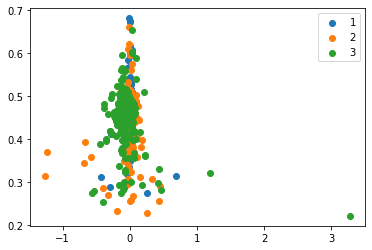

In [12]:
for type_label in [1,2,3]:
    data_category = data[data.category==type_label]
    plt.scatter(data_category.loc[:,"slope"], data_category.loc[:,"pwp_middle"], label=type_label)
    plt.legend()

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
for type_label in [1,2,3]:
    data_category = data[data.category==type_label]
    ax.scatter(data_category.loc[:,"pwp1"],data_category.loc[:,"pwp2"],data_category.loc[:,"m"], label=type_label)
plt.show()

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, classification_report, accuracy_score
from sklearn import preprocessing

In [14]:
X_values = data[['dist', 'extent', 'solidity', 'slope', 'pwp_limit', 'pwp_middle']]
y_values = data[['category']]

X_train, X_test, y_train, y_test = train_test_split(X_values, y_values.values.ravel(), test_size=0.2, random_state=seed)

In [15]:

models = [
            'ADB',
            'GBC',
            'RFC',
            'KNC'
         ]
clfs = [
        AdaBoostClassifier(random_state=seed),
        GradientBoostingClassifier(random_state=seed),
        RandomForestClassifier(random_state=seed,n_jobs=-1),
        KNeighborsClassifier(n_jobs=-1)
        ]
params = {
            models[0]: {'n_estimators':range(100,150,50)},
            models[1]: {'n_estimators':range(100,150,50), 'max_depth':range(5,9,2)},
            models[2]: {'criterion':['entropy'], 'n_estimators':range(10,100,10)},
            models[3]: {'n_neighbors':range(3,10), 'weights':['distance', 'uniform'],'leaf_size':range(5,30,5)}
         }

In [16]:
test_scores = []
y_estimation = 0
for name, estimator in zip(models,clfs):
    clf = GridSearchCV(estimator, params[name], scoring='accuracy', refit='True', n_jobs=-1, cv=10)
    clf.fit(X_train, y_train)
    test_scores.append((name, clf.best_params_, clf.best_score_))

In [17]:
results = pd.DataFrame(data=test_scores, columns=["name", "params", "acc_score"])
results.columns = ["Model", "Parameters", "Accuracy"]
results = results.sort_values(by=['Accuracy'], ascending=False,ignore_index=True)
results.Accuracy = results.Accuracy.round(4)
pd.set_option('display.max_colwidth', None)
results.to_latex('grid_search.txt', index = False, longtable = True)
results.head()

,Model,Parameters,Accuracy
0,RFC,"{'criterion': 'entropy', 'n_estimators': 70}",0.7381
1,GBC,"{'max_depth': 7, 'n_estimators': 100}",0.7346
2,KNC,"{'leaf_size': 5, 'n_neighbors': 8, 'weights': 'distance'}",0.7265
3,ADB,{'n_estimators': 100},0.6868


In [18]:
print("Best classifier: "+results.loc[0,'Model'])
print('params: '+str(results.loc[0,'Parameters']))
print('Accuracy test: '+str(results.loc[0,'Accuracy']))

Best classifier: RFC
params: {'criterion': 'entropy', 'n_estimators': 70}
Accuracy test: 0.7381


In [19]:
model_reduced = RandomForestClassifier(random_state=seed,n_jobs=-1, criterion = 'entropy', n_estimators=70)
model_reduced = model_reduced.fit(X_train, y_train)
y_predict_train = model_reduced.predict(X_train)
print(classification_report(y_train,y_predict_train, digits=4))
y_predict= model_reduced.predict(X_test)
print(classification_report(y_test,y_predict, digits=4))

              precision    recall  f1-score   support

           1     1.0000    1.0000    1.0000       344
           2     1.0000    1.0000    1.0000       313
           3     1.0000    1.0000    1.0000       202

    accuracy                         1.0000       859
   macro avg     1.0000    1.0000    1.0000       859
weighted avg     1.0000    1.0000    1.0000       859

              precision    recall  f1-score   support

           1     0.8851    0.8370    0.8603        92
           2     0.6707    0.7143    0.6918        77
           3     0.6739    0.6739    0.6739        46

    accuracy                         0.7581       215
   macro avg     0.7432    0.7417    0.7420       215
weighted avg     0.7631    0.7581    0.7601       215

